<a href="https://colab.research.google.com/github/sunandhini96/TSAI_ERAV1/blob/main/Session_18/VAE_Mnist.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from keras.layers import Lambda, Input, Dense, concatenate
from keras.models import Model
from keras.datasets import mnist
from keras.losses import binary_crossentropy
from keras import backend as K
from keras.optimizers import Adam
import numpy as np
import matplotlib.pyplot as plt

(x_train_data, y_train_data), (x_test_data, y_test_data) = mnist.load_data()
image_size = x_train_data.shape[1]
original_dim = image_size * image_size
x_train_data = np.reshape(x_train_data, [-1, original_dim])
x_test_data = np.reshape(x_test_data, [-1, original_dim])
x_train_data = x_train_data.astype('float32') / 255.0
x_test_data = x_test_data.astype('float32') / 255.0
# Define the number of classes for MNIST
num_classes = 10

# One-hot encode the labels
y_train_data = np.eye(num_classes)[y_train_data]
y_test_data = np.eye(num_classes)[y_test_data]

# Input shape for image and label
image_input_shape = (original_dim,)
label_input_shape = (num_classes,)

batch_size = 128


In [ ]:
def latent_sampling(args):
    z_mean_layer, z_log_var_layer = args
    batch = K.shape(z_mean_layer)[0]
    dimension = K.int_shape(z_mean_layer)[1]
    ep = K.random_normal(shape=(batch, dimension))
    return z_mean_layer + K.exp(0.5 * z_log_var_layer) * ep

def create_model(hidden_node, latent_node):
    # Define the input layers
    image_input = Input(shape=image_input_shape, name='input_image')
    label_input = Input(shape=label_input_shape, name='input_label')

    # Concatenate the image and label inputs
    combined_input = concatenate([image_input, label_input])

    # Build the encoder model
    encoder_hidden = Dense(hidden_node, activation='relu')(combined_input)

    z_mean = Dense(latent_node, name='z_mean')(encoder_hidden)
    z_log_var = Dense(latent_node, name='z_log_var')(encoder_hidden)

    z = Lambda(latent_sampling, output_shape=(latent_node,), name='z')([z_mean, z_log_var])

    encoder = Model([image_input, label_input], [z_mean, z_log_var, z], name='encoder')
    encoder.summary()

    # Build the decoder model
    latent_input = Input(shape=(latent_node,), name='latent_sampling')
    combined_input = concatenate([latent_input, label_input])

    decoder_hidden = Dense(hidden_node, activation='relu')(combined_input)
    decoder_outputs = Dense(original_dim, activation='sigmoid')(decoder_hidden)

    decoder = Model([latent_input, label_input], decoder_outputs, name='decoder')
    decoder.summary()

    # Build the VAE model
    model_outputs = decoder([encoder([image_input, label_input])[2], label_input])
    vae = Model([image_input, label_input], model_outputs, name='vae_mlp')

    reconstruction_loss = binary_crossentropy(image_input, model_outputs)
    reconstruction_loss *= original_dim

    kl_loss = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)
    kl_loss = K.sum(kl_loss, axis=-1)
    kl_loss *= -0.5
    vae_loss = K.mean(reconstruction_loss + kl_loss)
    vae.add_loss(vae_loss)
    vae.compile(optimizer=Adam(learning_rate=0.001))

    return vae, encoder, decoder

In [ ]:
def train_model(model):
    trained_model = model.fit([x_train_data, y_train_data],  # Provide both image and label data
                              epochs=epochs,
                              batch_size=batch_size,
                              validation_data=([x_test_data, y_test_data], None))
    return trained_model

    return trained_model

def plot_latent_space(encoder):
    input_data = [x_test_data, y_test_data]

    z_test, _, _ = encoder.predict(input_data, batch_size=batch_size)

    plt.figure(figsize=(12, 10))
    # Provide a single color (e.g., 'blue') for all points
    plt.scatter(z_test[:, 0], z_test[:, 1], c='blue')
    plt.xlabel("Z[0]")
    plt.ylabel("Z[1]")
    plt.savefig("VAE")
    plt.show()
import numpy as np
import matplotlib.pyplot as plt

def plot_vae_output(decoder, latent_dim, num_samples=20, digit_num=28):
    n = num_samples
    figure = np.zeros((digit_num * n, digit_num * n))

    # Generate random samples in the latent space
    latent_samples = np.random.normal(0, 1, size=(n, latent_dim))

    for i in range(n):
        for j in range(n):
            # Create an array of the current latent sample
            latent_sample = np.expand_dims(latent_samples[i, :], axis=0)

            # Create an array of labels (you need to provide labels)
            labels = np.zeros((1, num_classes))  # Replace with actual labels

            # Combine latent sample and labels as input
            input_to_decoder = [latent_sample, labels]

            # Generate an image from the combined input using the decoder
            decoded_image = decoder.predict(input_to_decoder)

            # Reshape the decoded image to match the digit's shape
            digit = decoded_image[0].reshape(digit_num, digit_num)

            # Place the digit in the figure
            figure[i * digit_num: (i + 1) * digit_num, j * digit_num: (j + 1) * digit_num] = digit

    plt.figure(figsize=(10, 10))
    plt.imshow(figure, cmap='Greys')
    plt.show()



Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_image (InputLayer)    [(None, 784)]                0         []                            
                                                                                                  
 input_label (InputLayer)    [(None, 10)]                 0         []                            
                                                                                                  
 concatenate_4 (Concatenate  (None, 794)                  0         ['input_image[0][0]',         
 )                                                                   'input_label[0][0]']         
                                                                                                  
 dense_6 (Dense)             (None, 256)                  203520    ['concatenate_4[0][0]'] 

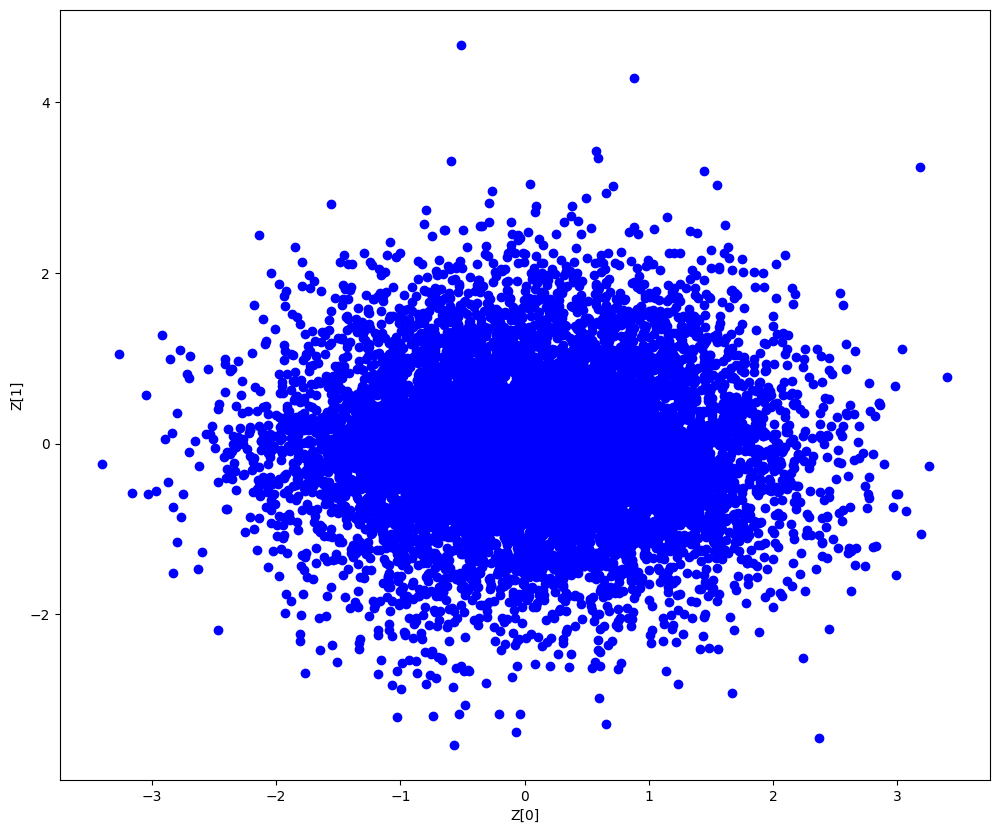

1/1 [==============================] - 0s 30ms/step


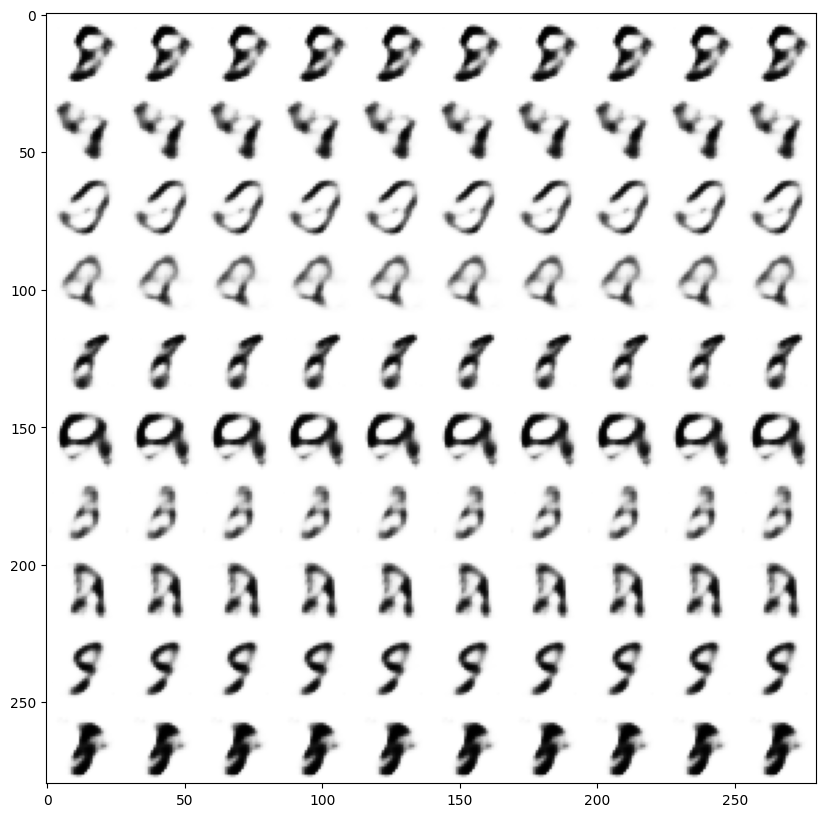

In [ ]:
# Create VAE model with 16 code units and generate images by varying each code unit from -3 to 3
intermediate_dim = 256
latent_dim = 16
epochs = 50
vae, encoder, decoder = create_model(intermediate_dim, latent_dim)
trained_model = train_model(vae)
plot_latent_space(encoder)
plot_vae_output(decoder, latent_dim)


1/1 [==============================] - 0s 28ms/step


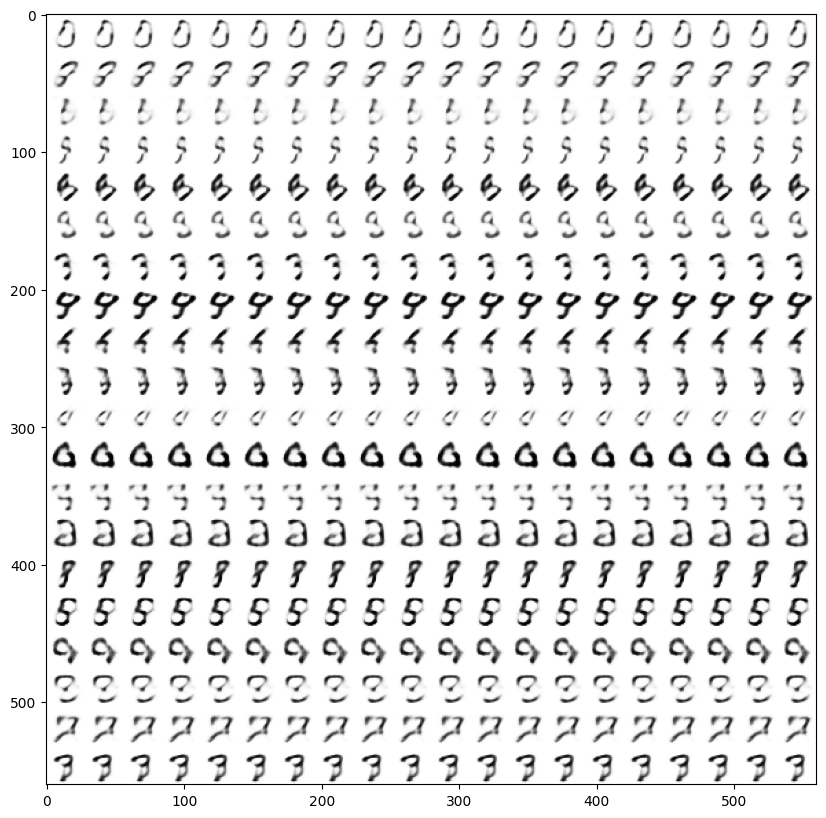

In [ ]:
plot_vae_output(decoder, latent_dim)

## wrong labelled predictions

1/1 [==============================] - 0s 25ms/step


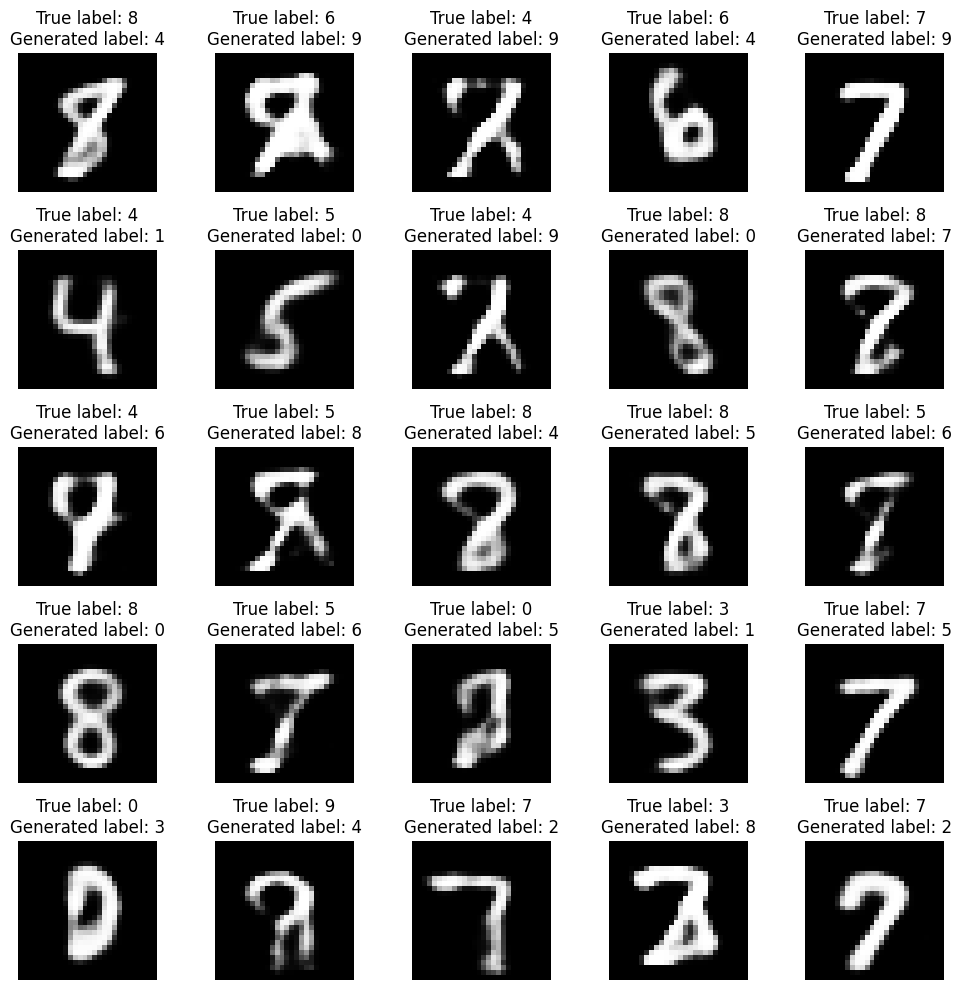

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Choose 25 random indices from the test set
num_samples = 25
indices = np.random.choice(range(len(x_test_data)), num_samples, replace=False)

# Generate wrong label codes
wrong_labels = np.random.randint(0, 10, num_samples)

# Ensure that wrong labels are different from true labels
true_labels = np.argmax(y_test_data[indices], axis=1)  # Convert one-hot labels to numbers
for i in range(num_samples):
    while wrong_labels[i] == true_labels[i]:
        wrong_labels[i] = np.random.randint(0, 10)

# Generate images with wrong labels
latent_samples, _, _ = encoder.predict([x_test_data[indices], y_test_data[indices]], batch_size=batch_size)
latent_samples[:, 0] = wrong_labels  # Replace the first dimension with wrong label codes
generated_images = decoder.predict([latent_samples, y_test_data[indices]])

# Plot the generated images
n = 5
fig, axs = plt.subplots(nrows=n, ncols=n, figsize=(10, 10))
for i in range(n * n):
    row = i // n
    col = i % n
    axs[row, col].imshow(generated_images[i].reshape(28, 28), cmap='gray')
    axs[row, col].axis('off')
    axs[row, col].set_title('True label: {}\nGenerated label: {}'.format(true_labels[i], wrong_labels[i]))
plt.tight_layout()
plt.show()



## Properly labeled predictions

1/1 [==============================] - 0s 43ms/step


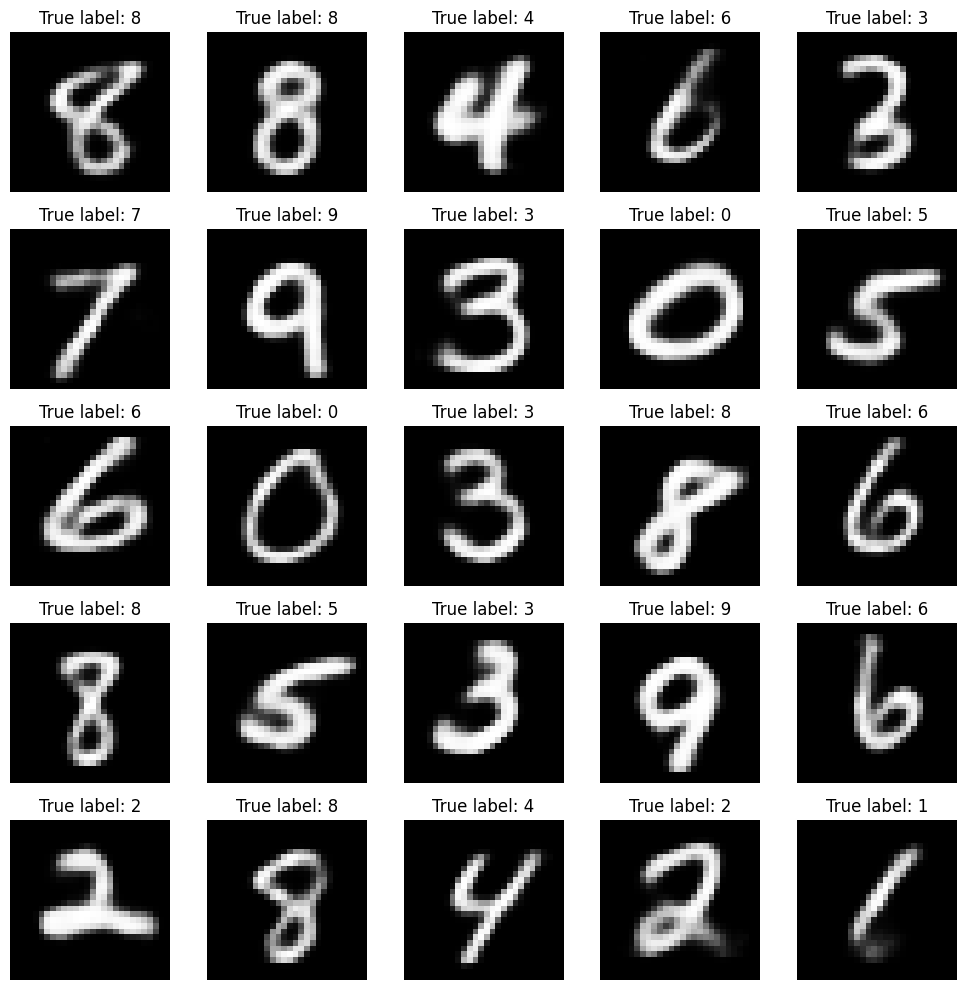

In [25]:
import numpy as np
import matplotlib.pyplot as plt

# Choose 25 random indices from the test set
num_samples = 25
indices = np.random.choice(range(len(x_test_data)), num_samples, replace=False)

# Generate images with correct labels
latent_samples, _, _ = encoder.predict([x_test_data[indices], y_test_data[indices]], batch_size=batch_size)
generated_images = decoder.predict([latent_samples, y_test_data[indices]])

# Get true labels for the selected samples
true_labels = np.argmax(y_test_data[indices], axis=1)  # Convert one-hot labels to numbers

# Plot the generated images with true labels
n = 5
fig, axs = plt.subplots(nrows=n, ncols=n, figsize=(10, 10))
for i in range(n * n):
    row = i // n
    col = i % n
    axs[row, col].imshow(generated_images[i].reshape(28, 28), cmap='gray')
    axs[row, col].axis('off')
    axs[row, col].set_title('True label: {}'.format(true_labels[i]))
plt.tight_layout()
plt.show()
